In [1]:
import os
import sys
import numpy as np
import gensim

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

### Import pre-processed dataset "Unique InchiKeys"

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


### Post-process data

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

In [4]:
len(spectrums_postprocessed)

12797

## Load and compare spec2vec similarities for 2 different models

In [5]:
filename = os.path.join(path_data, 'similarities_spec2vec_2dec_UniqueInchikeys_iter_50.npy')
matrix_similarities_spec2vec1 = np.load(filename)

In [6]:
filename = os.path.join(path_data, 'similarities_spec2vec_2dec_AllPosModel_iter_15.npy')
matrix_similarities_spec2vec2 = np.load(filename)

In [7]:
pearson_correlation = np.corrcoef(matrix_similarities_spec2vec1[:,:].flatten(),
                                  matrix_similarities_spec2vec2[:,:].flatten())

In [8]:
pearson_correlation

array([[1.        , 0.75746118],
       [0.75746118, 1.        ]])

In [63]:
bins = np.linspace(-0.5, 1, 16)
print(bins)

select_per_bin = 500
counts = []
selectedIDs_x = np.zeros((len(bins)-1)*select_per_bin)
selectedIDs_y = np.zeros((len(bins)-1)*select_per_bin)
for i, bin in enumerate(bins[1:], start=1):
    IDs = np.where((bins[i-1] <= matrix_similarities_spec2vec1)
                              & (matrix_similarities_spec2vec1 < bins[i]))
    counts.append(len(pair_selection))
    selects = np.random.choice(np.arange(IDs[0].shape[0]), select_per_bin, replace=False)
    selectedIDs_x[(i-1)*select_per_bin:i*select_per_bin] = IDs[0][selects]
    selectedIDs_y[(i-1)*select_per_bin:i*select_per_bin] = IDs[1][selects]


[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8
  0.9  1. ]


In [61]:
selectedIDs_x

array([12624.,  8949.,  9406., ...,  9270.,  1236., 10156.])

In [44]:
counts

[888,
 4966,
 206762,
 7708178,
 56107742,
 69159994,
 22785590,
 5388404,
 1553814,
 524810,
 187544,
 72536,
 30876,
 13778,
 7475]

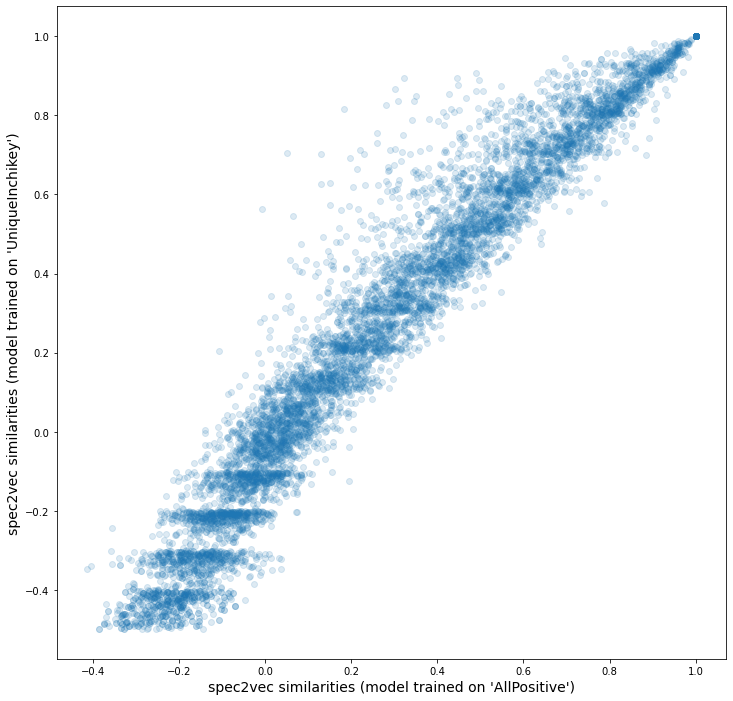

In [69]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,12))
plt.scatter(matrix_similarities_spec2vec2[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))],
            matrix_similarities_spec2vec1[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))], alpha=0.15)
plt.xlabel("spec2vec similarities (model trained on 'AllPositive')", fontsize=14)
plt.ylabel("spec2vec similarities (model trained on 'UniqueInchikey')", fontsize=14)
plt.savefig("correlation_spec2vec_different_models.png")

## Import reference similarity matrices for different scores

In [9]:
filename = os.path.join(path_data,'similarities_daylight2048_jaccard.npy')
matrix_similarities_fingerprint_daylight = np.load(filename)

In [12]:
matrix_similarities_fingerprint_daylight[np.isnan(matrix_similarities_fingerprint_daylight)] = 0

In [13]:
correlation_fingerprint_spec2vec1 = np.corrcoef(matrix_similarities_fingerprint_daylight[:,:].flatten(),
                                      matrix_similarities_spec2vec1[:,:].flatten())

print(correlation_fingerprint_spec2vec1)

[[1.         0.24626245]
 [0.24626245 1.        ]]


In [14]:
correlation_fingerprint_spec2vec2 = np.corrcoef(matrix_similarities_fingerprint_daylight[:,:].flatten(),
                                              matrix_similarities_spec2vec2[:,:].flatten())

print(correlation_fingerprint_spec2vec2)

[[1.         0.22906947]
 [0.22906947 1.        ]]


Text(0, 0.5, "spec2vec similarities (model trained on 'UniqueInchikey')")

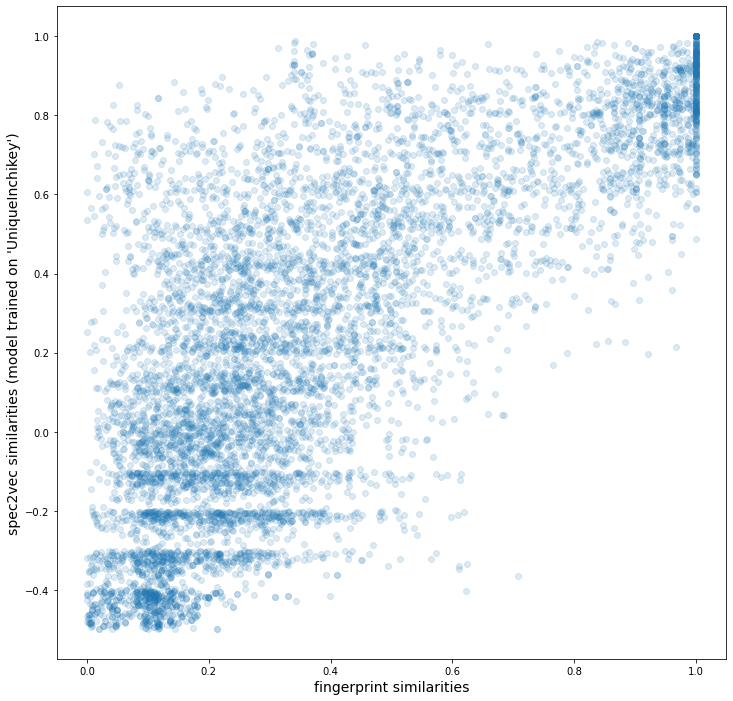

In [72]:
plt.figure(figsize=(12,12))
plt.scatter(matrix_similarities_fingerprint_daylight[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))],
            matrix_similarities_spec2vec1[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))], alpha=0.15)
plt.xlabel("fingerprint similarities", fontsize=14)
plt.ylabel("spec2vec similarities (model trained on 'UniqueInchikey')", fontsize=14)


In [73]:
filename = os.path.join(path_data,'similarities_mod_cosine_tol0005.npy')
matrix_similarities_mod_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_mod_cosine_tol0005_matches.npy')
matrix_matches_mod_cosine = np.load(filename)

In [74]:
matrix_similarities_mod_cosine[matrix_matches_mod_cosine < 10] = 0

Text(0, 0.5, "mod cosine')")

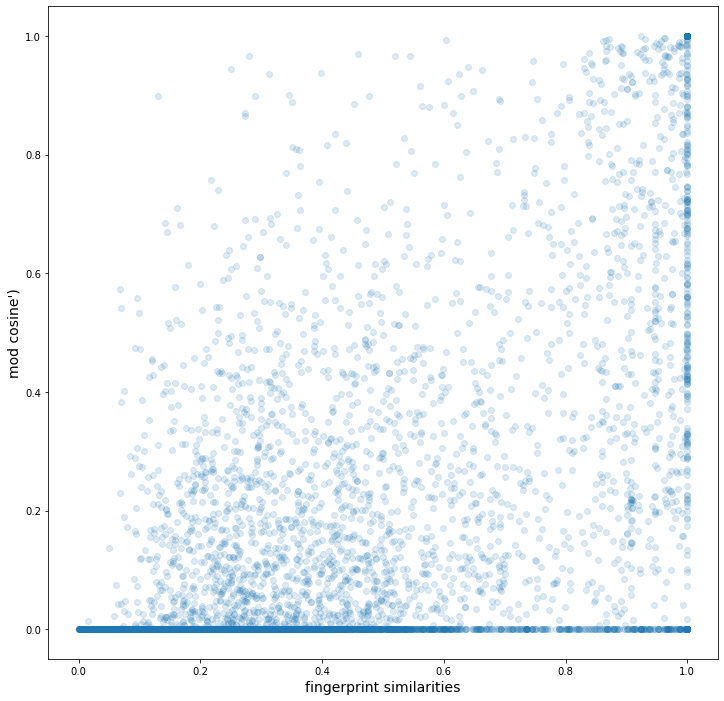

In [75]:
plt.figure(figsize=(12,12))
plt.scatter(matrix_similarities_fingerprint_daylight[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))],
            matrix_similarities_mod_cosine[(selectedIDs_x.astype(int), selectedIDs_y.astype(int))], alpha=0.15)
plt.xlabel("fingerprint similarities", fontsize=14)
plt.ylabel("mod cosine')", fontsize=14)
